In [2]:
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action= 'ignore')

# Load in MNIST

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
split = 60000
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
y_train, y_test = y_train.astype(np.uint8), y_test.astype(np.uint8)

# 1. Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. 

**K-Nearest Neighbor**

* A non-parametric algorithm which does not make assumptions about the data
* "Lazy Algorithm"
   * At training phase, stores data and classifies data into a category similar to new data
   * The n_neighbors parameter tells us how many nearest neighbors to look at to make decisions
* Basically find the k nearest neighbors, and calculate the euclidean distance of them and find the number of each class that is close and classify that way
   * Can also use the Manhattan distance - encourages sparsity with the l2 norm, which 0s out components with worse predictive power
      * This is the abs. value of the sum of differences for each feature rather than a straight line difference
   * Hamming distance, which can be used for categorical variables

----------------------------------------------
* We could do a brute force method that uses the number of other training instances as the number of neighbors
    * Really computationally expensive
* k-d tree turns into a binary hierarchical tree, ball trees are similar but efficient with high dimensions (creates two 100% separated clusters and checks new value compared to the two centroids, and it does this again for each other cluster to make a tree basically)


* One cool implementation I saw is collecting RGB values (color histogram) of an image to classify dog vs cat. A better example would be identifying the shape of signs in an image, and classifying based on the predominance of the color in it

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


neigh = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', algorithm = 'brute', p = 2)
  # weights : 'uniform', 'distance', or a custom function (accepts array of distances and returns array of same shape containing the weights)
    # uniform, all points have same weight -- Default
    # distance, points that are closer have more weight. by taking inverse of distance
  # algorithm: 'ball_tree', 'kd_tree', 'brute', 'auto'  --- sparse inputs make it use brute
    #auto default
  # leaf_size: Passed to Balltree or kd tree only. Optimal value depends on nature of the problem
    # 30 default
  # p: p=1, uses manhattan distance while p=2, euclidean distance is used
    # 2 default
  # metric: uses euclidean distance by default so change if needed

  #Attributes
    #classes_ : class labels known to classifier
    #effective_metric_ : the distance metric used
    #n_features_in_ : number of features seen during fit
    #feature_names_in_ : Names of features
    #n_samples_fit_ : number of samples fitted in data
neigh.fit(X_train, y_train)


KNeighborsClassifier(algorithm='brute')

In [7]:
predict_values = neigh.predict(X_test)

In [8]:
from sklearn import metrics
# sum(predict_values == y_test) / len(y_test)
print("Accuracy of model is:", metrics.accuracy_score(y_test, predict_values)*100, '%')

Accuracy of model is: 96.88 %


Running model with cross validation

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(neigh, X_train, y_train, cv = 5, scoring = 'accuracy')

array([0.96975   , 0.97016667, 0.96933333, 0.96816667, 0.969     ])

Predicting model with cross validation

In [10]:
from sklearn.model_selection import cross_val_predict
#just likec ross val score but instead of accuracy, it gives us "clean" predictions for each instance of the training

y_test_pred = cross_val_predict(neigh, X_test, y_test, cv = 3)

Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)

In [12]:
np.sum(cm, axis = 0) - 967

array([  46,  298,  -13,   73,   -8,  -95,    8,   83, -100,   38])

In [13]:
cm

array([[ 967,    1,    0,    0,    0,    3,    7,    1,    1,    0],
       [   0, 1129,    2,    2,    0,    0,    2,    0,    0,    0],
       [  17,   31,  933,    7,    5,    2,    5,   25,    5,    2],
       [   0,    6,    4,  956,    0,   16,    0,   12,   10,    6],
       [   0,   20,    2,    0,  909,    1,    7,    1,    0,   42],
       [   5,   10,    1,   34,    2,  815,   12,    1,    4,    8],
       [   9,    6,    1,    1,    3,    3,  935,    0,    0,    0],
       [   0,   39,    2,    0,    4,    2,    0,  958,    0,   23],
       [   7,   15,    6,   30,   15,   26,    6,   15,  844,   10],
       [   8,    8,    3,   10,   21,    4,    1,   37,    3,  914]])

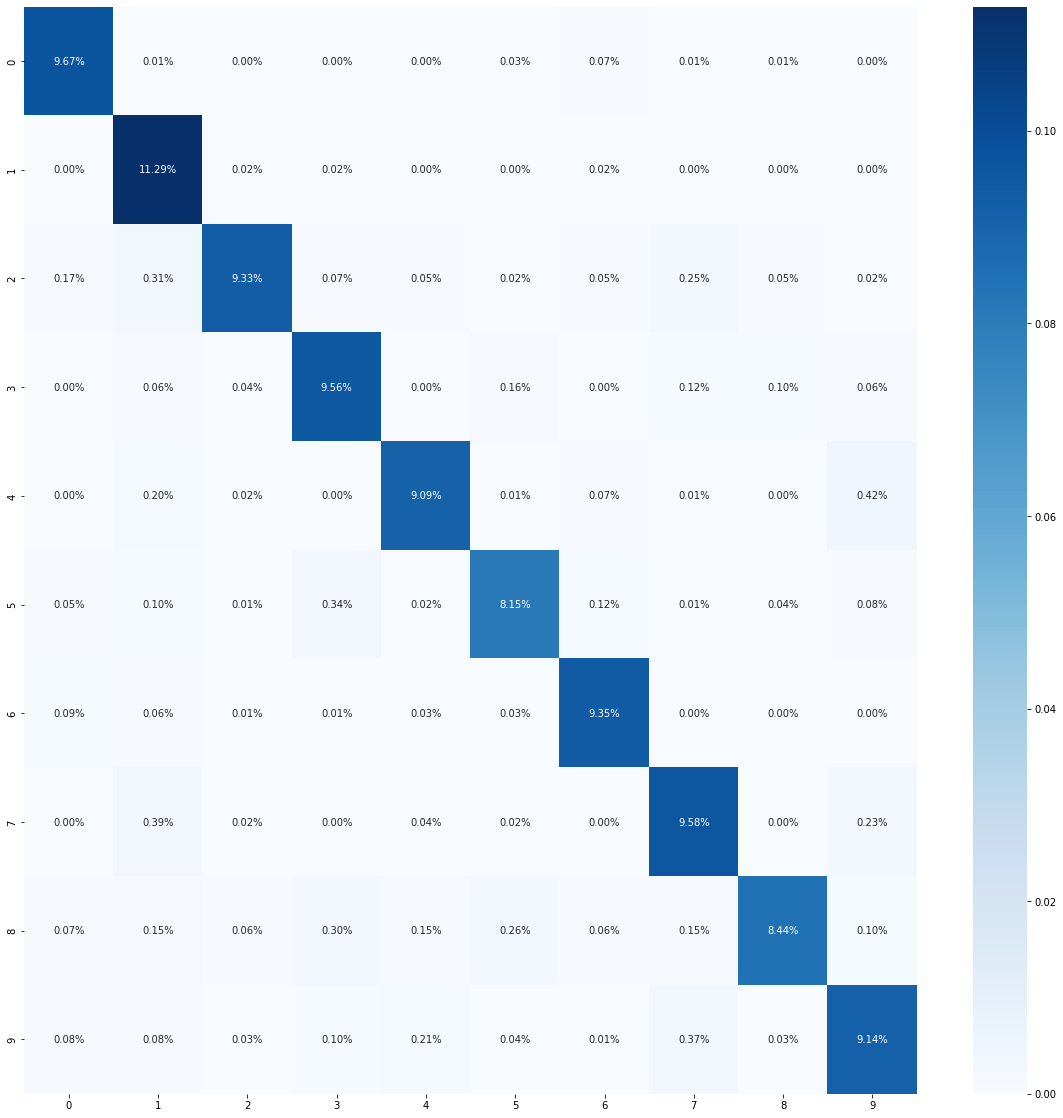

In [14]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(cm / np.sum(cm), annot = True, fmt='.2%', cmap = 'Blues')

In [15]:
#predicted are the columns
true_positives = list()
true_negatives = list()
false_negatives = list()
false_positives = list()
num_samples = list()
for i in range(len(cm)):
  true_positives.append(cm[i,i])
  true_negatives.append(np.sum(true_positives) - true_positives[i])
  false_negatives.append(np.sum(cm[i]) - true_positives[i])
  false_positives.append(np.sum(cm, axis = 0)[i] - true_positives[i])
  num_samples.append(np.sum(cm[i]))

In [16]:
#Weighted metrics

precision = np.array(true_positives) / (np.array(true_positives) + np.array(false_positives)) @ (np.array(num_samples) / np.sum(num_samples))
recall = np.array(true_positives) / (np.array(true_positives) + np.array(false_negatives)) @ (np.array(num_samples) / np.sum(num_samples))
f1_score = 2 * (precision * recall) / (precision + recall)

print('Weighted precision:', str(np.round(precision * 100,3)), '%  ', 'Weighted recall:', str(np.round(recall * 100,3)), '%  ', 'F1_score:', str(np.round(f1_score * 100, 3)), '%  ')

Weighted precision: 93.731 %   Weighted recall: 93.6 %   F1_score: 93.665 %  


In [17]:
print(metrics.classification_report(y_test, y_test_pred, digits = 9))

              precision    recall  f1-score   support

           0  0.954590326 0.986734694 0.970396387       980
           1  0.892490119 0.994713656 0.940833333      1135
           2  0.977987421 0.904069767 0.939577039      1032
           3  0.919230769 0.946534653 0.932682927      1010
           4  0.947862357 0.925661914 0.936630603       982
           5  0.934633028 0.913677130 0.924036281       892
           6  0.958974359 0.975991649 0.967408174       958
           7  0.912380952 0.931906615 0.922040423      1028
           8  0.973471742 0.866529774 0.916892993       974
           9  0.909452736 0.905847374 0.907646475      1009

    accuracy                      0.936000000     10000
   macro avg  0.938107381 0.935166723 0.935814464     10000
weighted avg  0.937309874 0.936000000 0.935800282     10000



Looking at the confusion matrix above we can see that 9s and 4s seem to get confused the most, but that overall our predictions are on point

# Exercise 2. Adjusting images with augmentation and running it again

* Shift all images one pixel up left right and down

In [76]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
  image = image.reshape((28,28))
  shifted_image = shift(image, [dy,dx], cval = 0)
  return shifted_image.reshape([-1])

X, y = mnist["data"], mnist["target"]
split = 60000
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
y_train, y_test = y_train.astype(np.uint8), y_test.astype(np.uint8)

In [81]:
X_train = np.array(X_train)
X_test = np.array(X_test)


In [83]:
X_train_expanded = [image for image in X_train]
y_train_expanded = [label for label in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
  for image, label in zip(X_train, y_train):
    X_train_expanded.append(shift_image(image, dx, dy))
    y_train_expanded.append(label)


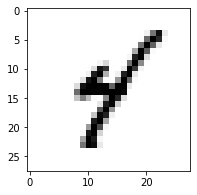

In [84]:
plt.figure(figsize = (12,3))
plt.imshow(X_train_expanded[-100].reshape(28,28), cmap = "Greys")
plt.show()

In [85]:
#Convert to numpy arrays
X_train_augmented = np.array(X_train_expanded)
y_train_augmented = np.array(y_train_expanded)


In [86]:
shuffle_idx = np.random.permutation(len(X_train_expanded))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [68]:
# X_train_expanded[[2,3,4]] #will just grab the rows that we want

In [89]:
neigh = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', algorithm = 'brute', p = 2)
neigh.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='brute')

In [90]:
predict_values = neigh.predict(X_test)

print("Accuracy of model is:", metrics.accuracy_score(y_test, predict_values)*100, '%')

Accuracy of model is: 97.54 %


We see an increase in accuracy after adding some data augmentation to the training data

In [92]:
print(len(y_test))

10000
